In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.optimizers import Adam

In [5]:
# 데이터 로드 함수
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [6]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [7]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [8]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week10/data/UCI HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week10/data/UCI HAR/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print("--- 데이터 로드 완료 ---")
    print(f"TrainX shape: {trainX.shape}, Trainy shape: {trainy.shape}")
    print(f"TestX shape: {testX.shape}, Testy shape: {testy.shape}")
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(prefix='')

/tmp/ipython-input-3817908449.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3817908449.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3817908449.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3817908449.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


--- 데이터 로드 완료 ---
TrainX shape: (7352, 128, 9), Trainy shape: (7352, 1)
TestX shape: (2947, 128, 9), Testy shape: (2947, 1)


In [9]:
# 데이터 스케일링
# 1. Scaler 객체 생성
scaler = StandardScaler()
# 2. 3D 데이터를 2D로 변환 (samples * timesteps, features)
n_samples_train, n_timesteps, n_features = trainX.shape
trainX_reshaped = trainX.reshape(-1, n_features)
# 3. train 데이터로 scaler를 'fit' (통계 계산) 및 'transform' (스케일링)
trainX_scaled_reshaped = scaler.fit_transform(trainX_reshaped)
# 4. 스케일링된 2D 데이터를 다시 3D로 변환
trainX = trainX_scaled_reshaped.reshape(n_samples_train, n_timesteps, n_features)
# 5. testX도 2D로 변환 (fit 없이 transform만 적용)
n_samples_test = testX.shape[0]
testX_reshaped = testX.reshape(-1, n_features)
# 6. 'fit' 없이 'transform'만 적용 (중요: train 데이터의 통계 사용)
testX_scaled_reshaped = scaler.transform(testX_reshaped)
# 7. testX를 다시 3D로 변환
testX = testX_scaled_reshaped.reshape(n_samples_test, n_timesteps, n_features)
print("\n--- 데이터 스케일링 완료 (StandardScaler) ---")


--- 데이터 스케일링 완료 (StandardScaler) ---


In [10]:
# Validation 데이터 분리
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

print("\n--- Train/Validation 분리 완료 ---")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]


--- Train/Validation 분리 완료 ---
X_train shape: (5881, 128, 9), y_train shape: (5881, 1)
X_val shape: (1471, 128, 9), y_val shape: (1471, 1)


In [11]:
# AE 학습을 위한 '정상' 데이터 추출

# '정상' 클래스 정의: 'WALKING' (레이블 0)
NORMAL_CLASS_LABEL = 0
LABELS = ["Normal (Walking)", "Anomaly (Other)"]

# y_train (2D, shape=(N, 1))을 1D로 변환하여 필터링
y_train_flat = y_train.flatten()
y_val_flat = y_val.flatten()

# 훈련(X_train) 세트에서 '정상' 데이터만 추출
X_train_normal = X_train[y_train_flat == NORMAL_CLASS_LABEL]
# 검증(X_val) 세트에서 '정상' 데이터만 추출 (AE 검증용)
X_val_normal = X_val[y_val_flat == NORMAL_CLASS_LABEL]

print("\n--- AE 훈련용 '정상' 데이터 추출 완료 ---")
print(f"원본 X_train shape: {X_train.shape}")
print(f"정상 데이터 X_train_normal shape: {X_train_normal.shape}")
print(f"정상 데이터 X_val_normal shape: {X_val_normal.shape}")


--- AE 훈련용 '정상' 데이터 추출 완료 ---
원본 X_train shape: (5881, 128, 9)
정상 데이터 X_train_normal shape: (983, 128, 9)
정상 데이터 X_val_normal shape: (243, 128, 9)


In [16]:
# 오토인코더 모델 정의
input_shape = (n_timesteps, n_features) # (128, 9)
original_dim = n_timesteps * n_features # 1152
encoding_dim_1 = 128
encoding_dim_2 = 32  # 병목(Bottleneck)

input_layer = Input(shape=input_shape)
flat_layer = Flatten()(input_layer)
encoded = Dense(encoding_dim_1, activation='relu')(flat_layer)
encoded = Dense(encoding_dim_2, activation='relu')(encoded)
decoded = Dense(encoding_dim_1, activation='relu')(encoded)
decoded = Dense(original_dim, activation=None)(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

# tf.function 오류를 우회하기 위해 'run_eagerly=True' 추가
autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                    loss='mse',
                    run_eagerly=True)

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1152)           │       148,608 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,544 (1.16 MB)

 Trainable params: 304,544 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# 훈련 데이터의 타겟(Y)을 2D로 Reshape
n_samples_train_normal = X_train_normal.shape[0]
y_train_target = X_train_normal.reshape(n_samples_train_normal, original_dim)

# 검증 데이터의 타겟(Y)을 2D로 Reshape
n_samples_val_normal = X_val_normal.shape[0]
y_val_target = X_val_normal.reshape(n_samples_val_normal, original_dim)

print(f"\n--- AE 학습을 위한 타겟 데이터 Reshape 완료 ---")
print(f"X_train_normal (Input) shape: {X_train_normal.shape}")
print(f"y_train_target (Target) shape: {y_train_target.shape}")
print(f"X_val_normal (Val Input) shape: {X_val_normal.shape}")
print(f"y_val_target (Val Target) shape: {y_val_target.shape}")


--- AE 학습을 위한 타겟 데이터 Reshape 완료 ---
X_train_normal (Input) shape: (983, 128, 9)
y_train_target (Target) shape: (983, 1152)
X_val_normal (Val Input) shape: (243, 128, 9)
y_val_target (Val Target) shape: (243, 1152)


In [18]:
# 모델 학습
# Input(X)은 3D (X_train_normal)로, Target(Y)은 2D (y_train_target)로 전달
history = autoencoder.fit(X_train_normal, y_train_target,  # <- Y 타겟 수정
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_val_normal, y_val_target)) # <- Validation 타겟 수정

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.3626 - val_loss: 1.3315
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.3113 - val_loss: 1.2714
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.2502 - val_loss: 1.2082
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.1769 - val_loss: 1.1410
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.1230 - val_loss: 1.0722
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.0275 - val_loss: 1.0047
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.9597 - val_loss: 0.9489
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.9217 - val_loss: 0.9103
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.8669 - val_loss: 0.8809
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.8503 - val_loss: 0.8569
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.8278 - val_loss: 0.8369
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.7970 - val_loss: 0.818

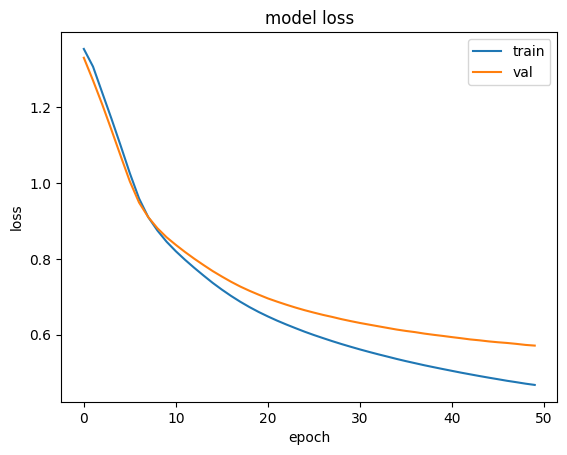

In [36]:
# Loss 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');
plt.show()

In [23]:
# Reconstruction Error 계산 ---
# 원본 testX (정상+이상) 데이터로 예측 수행
predictions = autoencoder.predict(testX)

# MSE 계산을 위해 testX도 2D로 Flatten
testX_flat = testX.reshape(n_samples_test, original_dim)

# (N, 1) 형태의 testy 레이블을 1D로 변환
testy_flat = testy.flatten()

# '정상'(0) vs '이상'(1)의 2진 레이블 생성
testy_binary = np.where(testy_flat == NORMAL_CLASS_LABEL, 0, 1)

# 샘플별 평균 제곱 오차 (Reconstruction Error) 계산
mse = np.mean(np.power(testX_flat - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': testy_binary})

print("\n--- Reconstruction Error 통계 (Test Set) ---")
print(error_df.describe())
print("---------------------------------------------")

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

--- Reconstruction Error 통계 (Test Set) ---
       reconstruction_error   true_class
count           2947.000000  2947.000000
mean               0.796455     0.831693
std                0.708974     0.374202
min                0.019693     0.000000
25%                0.085854     1.000000
50%                0.651441     1.000000
75%                1.385117     1.000000
max                2.863009     1.000000
---------------------------------------------


In [33]:
# Threshold 설정 및 평가 ---

threshold = 2.0

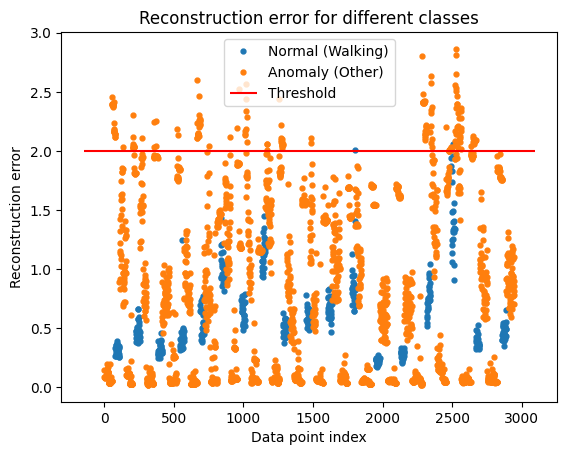

In [34]:
# Reconstruction Error 시각화
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= LABELS[name])
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

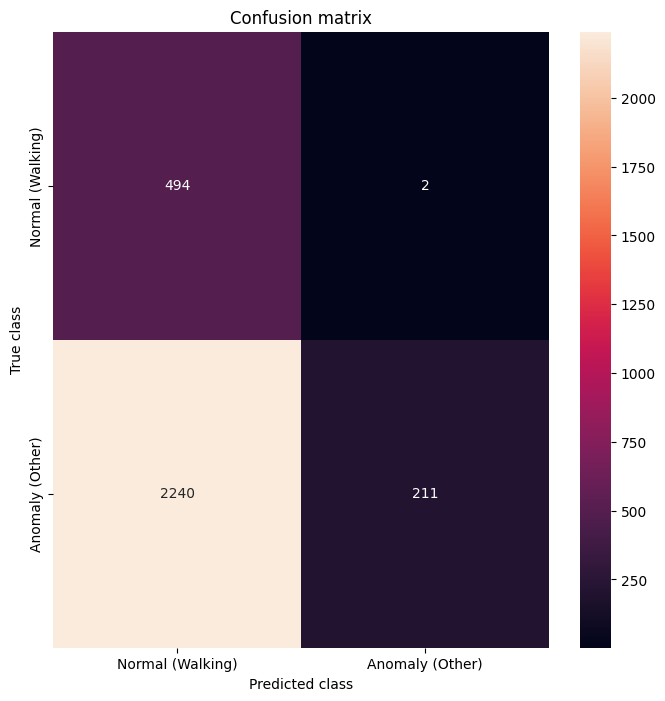

                  precision    recall  f1-score   support

Normal (Walking)       0.18      1.00      0.31       496
 Anomaly (Other)       0.99      0.09      0.16      2451

        accuracy                           0.24      2947
       macro avg       0.59      0.54      0.23      2947
    weighted avg       0.85      0.24      0.18      2947



In [35]:
# Confusion Matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred, target_names=LABELS))